# Glacier mapping with random forest

In [36]:
import sklearn
import sklearn.ensemble
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import utils.misc
import os

In [17]:
# configuration variables
samples_per_image = 2500
n_features = 10

data_folder = os.path.join("/home", "eouser", "data", "glaciermapping")

### Reading training data

In [5]:
# open training subset
train = h5py.File(os.path.join(data_folder, "train.hdf5"), "r")

In [18]:
# read tile-by-tile and sample `samples_per_image` pixels from every tile for training
np.random.seed(42)

xs = []
ys = []

for tile in tqdm(train.keys()):
    group = train[tile]

    features = np.array(group["features"])
    outlines = np.array(group["outlines"])
    pad_height, pad_width = group.attrs["pad_height"], group.attrs["pad_width"]
    height, width = group.attrs["height"], group.attrs["width"]
    
    features = features[pad_height:pad_height + height, pad_width:pad_width + width, :]
    outlines = outlines[pad_height:pad_height + height, pad_width:pad_width + width, 1]
    
    features = features.reshape((height * width, n_features))
    outlines = outlines.reshape((height * width, ))
    sample_idxs = np.random.choice(features.shape[0], size=samples_per_image, replace=False)
    samples_x = features[sample_idxs]
    samples_y = outlines[sample_idxs]

    xs.extend(samples_x)
    ys.extend(samples_y)
    
ys = [int(_) for _ in ys]

100%|███████████████████████████████████████████████████████████████████████████████| 234/234 [00:24<00:00,  9.65it/s]


In [27]:
# close training subset
train.close()

### Defining model and training

In [24]:
# create random forest, see https://scikit-learn.org/stable/supervised_learning.html
classifier = sklearn.ensemble.RandomForestClassifier(
    n_jobs=-1, # to use all CPU cores
    # verbose=11 # to report log info
)

In [25]:
# train model
classifier.fit(xs, ys)

RandomForestClassifier(n_jobs=-1)

In [26]:
# score it on train subset (to verify model overfits on it)
classifier.score(xs, ys)

0.999991452991453

In [28]:
# save model for later use
with open(os.path.join("weights", "random_forest.pickle"), "wb") as classifier_file:
    pickle.dump(classifier, classifier_file)

In [29]:
# to load model use this code snippet
with open(os.path.join("weights", "random_forest.pickle"), "rb") as classifier_file:
    classifier = pickle.load(classifier_file)

### Evaluating model performance

In [40]:
# open test subset
test = h5py.File(os.path.join(data_folder, "test.hdf5"), "r")

In [41]:
# classify test samples
results = {}

for tile in tqdm(test.keys()):
    group = test[tile]

    features = np.array(group["features"])
    outlines = np.array(group["outlines"])
    pad_height, pad_width = group.attrs["pad_height"], group.attrs["pad_width"]
    height, width = group.attrs["height"], group.attrs["width"]
    
    features = features[pad_height:pad_height + height, pad_width:pad_width + width, :]
    outlines = outlines[pad_height:pad_height + height, pad_width:pad_width + width, 1]
    
    features = features.reshape((height * width, n_features))

    prediction = classifier.predict(features)
    prediction = prediction.reshape((height, width))
    
    results[tile] = {
        "thumbnail": features.reshape((height, width, n_features))[:, :, [5, 3, 2]],
        "outlines": outlines,
        "prediction": prediction
    }


100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [02:11<00:00,  1.65s/it]


In [42]:
# close test subset
test.close()

In [43]:
# calculate metrics
tp, fp, fn = 0, 0, 0

for tile, result in tqdm(results.items()):
    groundtruth = result["outlines"]
    prediction = result["prediction"]

    tp_mask = (prediction == 1) & (groundtruth == 1)
    fp_mask = (prediction == 1) & (groundtruth == 0)
    fn_mask = (prediction == 0) & (groundtruth == 1)

    tp += np.sum(tp_mask)
    fp += np.sum(fp_mask)
    fn += np.sum(fn_mask)
        
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
iou = tp / (tp + fp + fn)

print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1-score = {f1}")
print(f"iou = {iou}")

100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 289.99it/s]

precision = 0.8850291043477825
recall = 0.8375773569329469
f1-score = 0.8606496662937386
iou = 0.7553863292373642


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


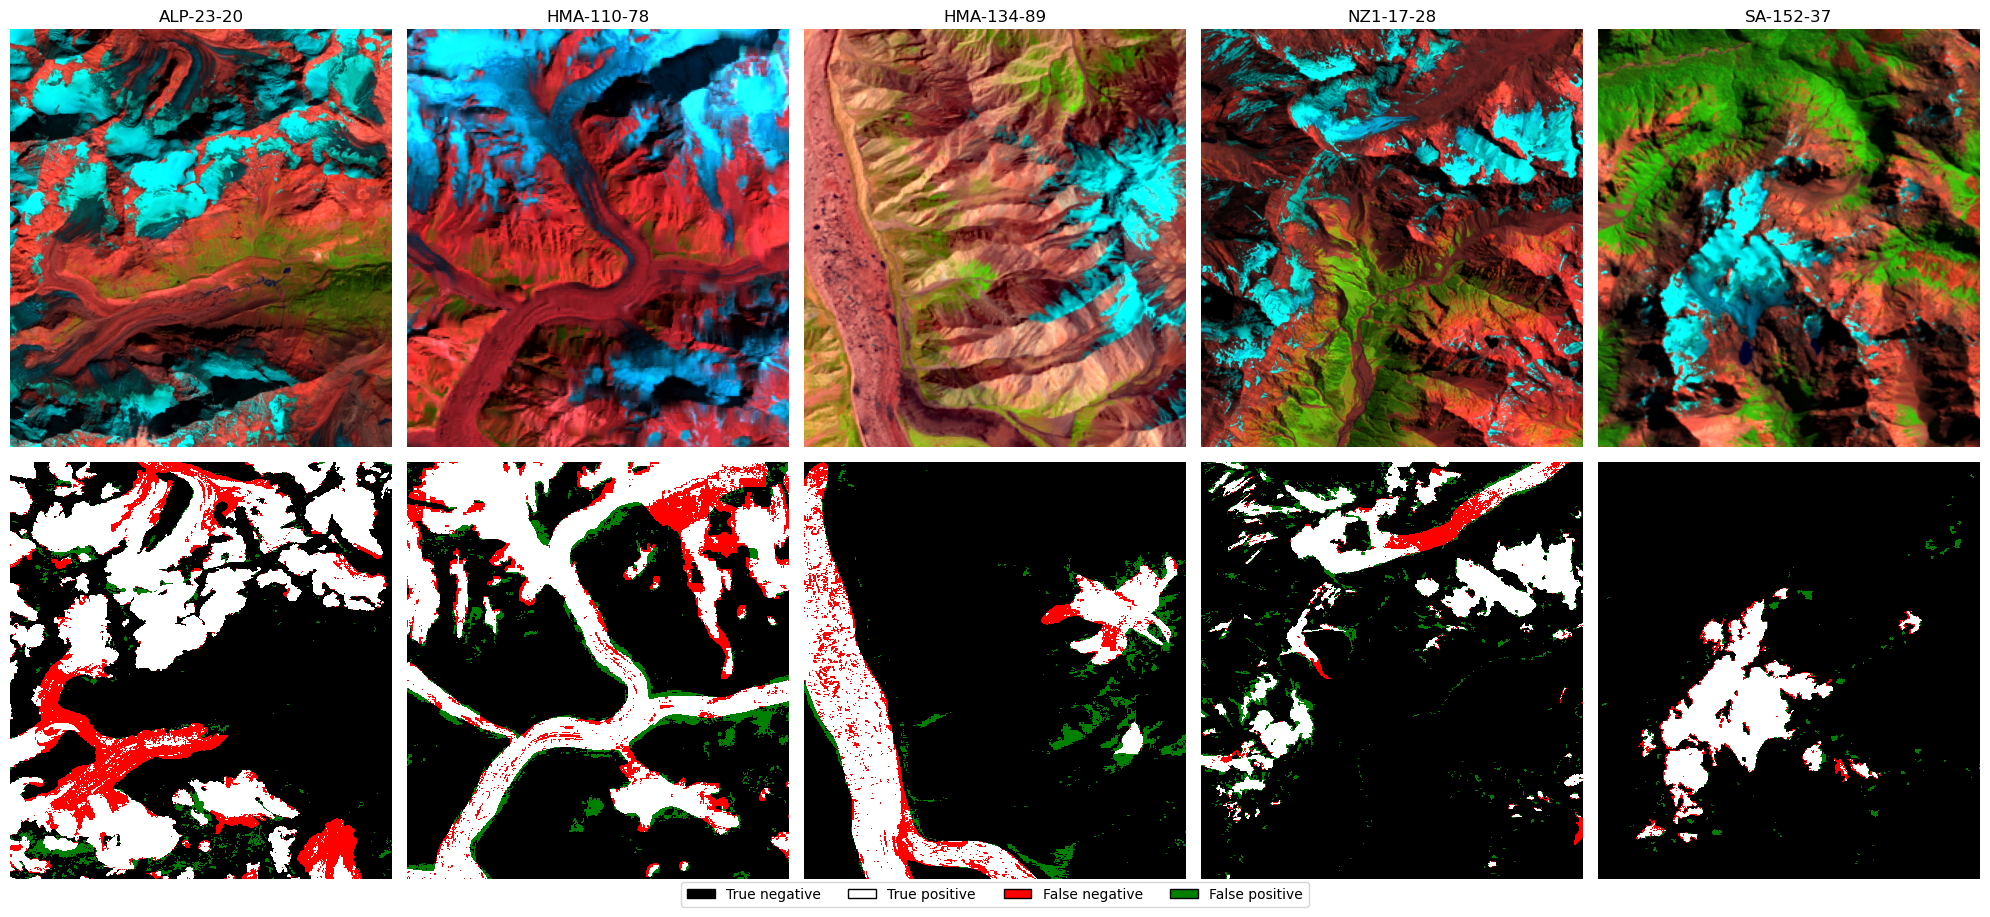

In [68]:
# visualise some tiles
tiles_to_visualise = [
    "ALP-23-20", 
    "HMA-110-78", 
    "HMA-134-89", 
    "NZ1-17-28", 
    "SA-152-37",
]

nrows, ncols = 2, len(tiles_to_visualise)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4.5 * nrows))

for col, tile in enumerate(tiles_to_visualise):
    axes[0][col].set_title(tile)
    
    thumbnail = utils.misc.norm_to_vis(results[tile]["thumbnail"])
    axes[0][col].imshow(thumbnail, aspect="auto")
    
    groundtruth = results[tile]["outlines"]
    prediction = results[tile]["prediction"]
    
    output_colors = ["black", "white", "red", "green"]
    output_cmap = mpl.colors.ListedColormap(output_colors, 4)
    output = np.zeros(prediction.shape)
    output[(prediction == 1) & (groundtruth == 1)] = 1
    output[(prediction == 0) & (groundtruth == 1)] = 2
    output[(prediction == 1) & (groundtruth == 0)] = 3
    axes[1][col].imshow(
        output / 3, vmin=0, vmax=1, aspect="auto", cmap=output_cmap, 
        interpolation="none"
    )

for row in range(nrows):
    for col in range(ncols):
        axes[row][col].axis("off")
    
labels = ["True negative", "True positive", "False negative", "False positive"]
handles = [mpl.patches.Patch(facecolor=_, edgecolor="black") for _ in output_colors]

fig.legend(handles, labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.022))

plt.tight_layout()
plt.show()